# Training : Unconditional image generation
- Ref: https://huggingface.co/docs/diffusers/v0.34.0/en/training/unconditional_training

In [13]:
#@title
import torch

if torch.backends.mps.is_available():
    t_device = torch.device("mps")
    s_device = "mps"
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
elif torch.cuda.is_available():
    t_device = torch.device("cuda")
    s_device = "cuda"
else:
    t_device = torch.device("cpu")
    s_device = "cpu"
print(s_device)

cuda


### 1. Setup acclerate

In [2]:
! accelerate config default

Configuration already exists at /home/hyunjae/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


### 2. Prepare a training script
- Ref: https://github.com/huggingface/diffusers/blob/main/examples/unconditional_image_generation/train_unconditional.py

In [1]:
%%writefile temp_train_unconditional.py

import argparse
import inspect
import logging
import math
import os
import shutil
from datetime import timedelta
from pathlib import Path

import accelerate
import datasets
import torch
import torch.nn.functional as F
from accelerate import Accelerator, InitProcessGroupKwargs
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration
from datasets import load_dataset
from huggingface_hub import create_repo, upload_folder
from packaging import version
from torchvision import transforms
from tqdm.auto import tqdm

import diffusers
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from diffusers.utils import check_min_version, is_accelerate_version, is_tensorboard_available, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available


# Will error if the minimal version of diffusers is not installed. Remove at your own risks.
# check_min_version("0.35.0.dev0")

logger = get_logger(__name__, log_level="INFO")


def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    if not isinstance(arr, torch.Tensor):
        arr = torch.from_numpy(arr)
    res = arr[timesteps].float().to(timesteps.device)
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


def parse_args():
    parser = argparse.ArgumentParser(description="Simple example of a training script.")
    parser.add_argument(
        "--dataset_name",
        type=str,
        default=None,
        help=(
            "The name of the Dataset (from the HuggingFace hub) to train on (could be your own, possibly private,"
            " dataset). It can also be a path pointing to a local copy of a dataset in your filesystem,"
            " or to a folder containing files that HF Datasets can understand."
        ),
    )
    parser.add_argument(
        "--dataset_config_name",
        type=str,
        default=None,
        help="The config of the Dataset, leave as None if there's only one config.",
    )
    parser.add_argument(
        "--model_config_name_or_path",
        type=str,
        default=None,
        help="The config of the UNet model to train, leave as None to use standard DDPM configuration.",
    )
    parser.add_argument(
        "--train_data_dir",
        type=str,
        default=None,
        help=(
            "A folder containing the training data. Folder contents must follow the structure described in"
            " https://huggingface.co/docs/datasets/image_dataset#imagefolder. In particular, a `metadata.jsonl` file"
            " must exist to provide the captions for the images. Ignored if `dataset_name` is specified."
        ),
    )
    parser.add_argument(
        "--output_dir",
        type=str,
        default="ddpm-model-64",
        help="The output directory where the model predictions and checkpoints will be written.",
    )
    parser.add_argument("--overwrite_output_dir", action="store_true")
    parser.add_argument(
        "--cache_dir",
        type=str,
        default=None,
        help="The directory where the downloaded models and datasets will be stored.",
    )
    parser.add_argument(
        "--resolution",
        type=int,
        default=64,
        help=(
            "The resolution for input images, all the images in the train/validation dataset will be resized to this"
            " resolution"
        ),
    )
    parser.add_argument(
        "--center_crop",
        default=False,
        action="store_true",
        help=(
            "Whether to center crop the input images to the resolution. If not set, the images will be randomly"
            " cropped. The images will be resized to the resolution first before cropping."
        ),
    )
    parser.add_argument(
        "--random_flip",
        default=False,
        action="store_true",
        help="whether to randomly flip images horizontally",
    )
    parser.add_argument(
        "--train_batch_size", type=int, default=16, help="Batch size (per device) for the training dataloader."
    )
    parser.add_argument(
        "--eval_batch_size", type=int, default=16, help="The number of images to generate for evaluation."
    )
    parser.add_argument(
        "--dataloader_num_workers",
        type=int,
        default=0,
        help=(
            "The number of subprocesses to use for data loading. 0 means that the data will be loaded in the main"
            " process."
        ),
    )
    parser.add_argument("--num_epochs", type=int, default=100)
    parser.add_argument("--save_images_epochs", type=int, default=10, help="How often to save images during training.")
    parser.add_argument(
        "--save_model_epochs", type=int, default=10, help="How often to save the model during training."
    )
    parser.add_argument(
        "--gradient_accumulation_steps",
        type=int,
        default=1,
        help="Number of updates steps to accumulate before performing a backward/update pass.",
    )
    parser.add_argument(
        "--learning_rate",
        type=float,
        default=1e-4,
        help="Initial learning rate (after the potential warmup period) to use.",
    )
    parser.add_argument(
        "--lr_scheduler",
        type=str,
        default="cosine",
        help=(
            'The scheduler type to use. Choose between ["linear", "cosine", "cosine_with_restarts", "polynomial",'
            ' "constant", "constant_with_warmup"]'
        ),
    )
    parser.add_argument(
        "--lr_warmup_steps", type=int, default=500, help="Number of steps for the warmup in the lr scheduler."
    )
    parser.add_argument("--adam_beta1", type=float, default=0.95, help="The beta1 parameter for the Adam optimizer.")
    parser.add_argument("--adam_beta2", type=float, default=0.999, help="The beta2 parameter for the Adam optimizer.")
    parser.add_argument(
        "--adam_weight_decay", type=float, default=1e-6, help="Weight decay magnitude for the Adam optimizer."
    )
    parser.add_argument("--adam_epsilon", type=float, default=1e-08, help="Epsilon value for the Adam optimizer.")
    parser.add_argument(
        "--use_ema",
        action="store_true",
        help="Whether to use Exponential Moving Average for the final model weights.",
    )
    parser.add_argument("--ema_inv_gamma", type=float, default=1.0, help="The inverse gamma value for the EMA decay.")
    parser.add_argument("--ema_power", type=float, default=3 / 4, help="The power value for the EMA decay.")
    parser.add_argument("--ema_max_decay", type=float, default=0.9999, help="The maximum decay magnitude for EMA.")
    parser.add_argument("--push_to_hub", action="store_true", help="Whether or not to push the model to the Hub.")
    parser.add_argument("--hub_token", type=str, default=None, help="The token to use to push to the Model Hub.")
    parser.add_argument(
        "--hub_model_id",
        type=str,
        default=None,
        help="The name of the repository to keep in sync with the local `output_dir`.",
    )
    parser.add_argument(
        "--hub_private_repo", action="store_true", help="Whether or not to create a private repository."
    )
    parser.add_argument(
        "--logger",
        type=str,
        default="tensorboard",
        choices=["tensorboard", "wandb"],
        help=(
            "Whether to use [tensorboard](https://www.tensorflow.org/tensorboard) or [wandb](https://www.wandb.ai)"
            " for experiment tracking and logging of model metrics and model checkpoints"
        ),
    )
    parser.add_argument(
        "--logging_dir",
        type=str,
        default="logs",
        help=(
            "[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to"
            " *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."
        ),
    )
    parser.add_argument("--local_rank", type=int, default=-1, help="For distributed training: local_rank")
    parser.add_argument(
        "--mixed_precision",
        type=str,
        default="no",
        choices=["no", "fp16", "bf16"],
        help=(
            "Whether to use mixed precision. Choose"
            "between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >= 1.10."
            "and an Nvidia Ampere GPU."
        ),
    )
    parser.add_argument(
        "--prediction_type",
        type=str,
        default="epsilon",
        choices=["epsilon", "sample"],
        help="Whether the model should predict the 'epsilon'/noise error or directly the reconstructed image 'x0'.",
    )
    parser.add_argument("--ddpm_num_steps", type=int, default=1000)
    parser.add_argument("--ddpm_num_inference_steps", type=int, default=1000)
    parser.add_argument("--ddpm_beta_schedule", type=str, default="linear")
    parser.add_argument(
        "--checkpointing_steps",
        type=int,
        default=500,
        help=(
            "Save a checkpoint of the training state every X updates. These checkpoints are only suitable for resuming"
            " training using `--resume_from_checkpoint`."
        ),
    )
    parser.add_argument(
        "--checkpoints_total_limit",
        type=int,
        default=None,
        help=("Max number of checkpoints to store."),
    )
    parser.add_argument(
        "--resume_from_checkpoint",
        type=str,
        default=None,
        help=(
            "Whether training should be resumed from a previous checkpoint. Use a path saved by"
            ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint.'
        ),
    )
    parser.add_argument(
        "--enable_xformers_memory_efficient_attention", action="store_true", help="Whether or not to use xformers."
    )

    args = parser.parse_args()
    env_local_rank = int(os.environ.get("LOCAL_RANK", -1))
    if env_local_rank != -1 and env_local_rank != args.local_rank:
        args.local_rank = env_local_rank

    if args.dataset_name is None and args.train_data_dir is None:
        raise ValueError("You must specify either a dataset name from the hub or a train data directory.")

    return args


def main(args):
    logging_dir = os.path.join(args.output_dir, args.logging_dir)
    accelerator_project_config = ProjectConfiguration(project_dir=args.output_dir, logging_dir=logging_dir)

    kwargs = InitProcessGroupKwargs(timeout=timedelta(seconds=7200))  # a big number for high resolution or big dataset
    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
        log_with=args.logger,
        project_config=accelerator_project_config,
        kwargs_handlers=[kwargs],
    )

    if args.logger == "tensorboard":
        if not is_tensorboard_available():
            raise ImportError("Make sure to install tensorboard if you want to use it for logging during training.")

    elif args.logger == "wandb":
        if not is_wandb_available():
            raise ImportError("Make sure to install wandb if you want to use it for logging during training.")
        import wandb

    # `accelerate` 0.16.0 will have better support for customized saving
    if version.parse(accelerate.__version__) >= version.parse("0.16.0"):
        # create custom saving & loading hooks so that `accelerator.save_state(...)` serializes in a nice format
        def save_model_hook(models, weights, output_dir):
            if accelerator.is_main_process:
                if args.use_ema:
                    ema_model.save_pretrained(os.path.join(output_dir, "unet_ema"))

                for i, model in enumerate(models):
                    model.save_pretrained(os.path.join(output_dir, "unet"))

                    # make sure to pop weight so that corresponding model is not saved again
                    weights.pop()

        def load_model_hook(models, input_dir):
            if args.use_ema:
                load_model = EMAModel.from_pretrained(os.path.join(input_dir, "unet_ema"), UNet2DModel)
                ema_model.load_state_dict(load_model.state_dict())
                ema_model.to(accelerator.device)
                del load_model

            for i in range(len(models)):
                # pop models so that they are not loaded again
                model = models.pop()

                # load diffusers style into model
                load_model = UNet2DModel.from_pretrained(input_dir, subfolder="unet")
                model.register_to_config(**load_model.config)

                model.load_state_dict(load_model.state_dict())
                del load_model

        accelerator.register_save_state_pre_hook(save_model_hook)
        accelerator.register_load_state_pre_hook(load_model_hook)

    # Make one log on every process with the configuration for debugging.
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)
    if accelerator.is_local_main_process:
        datasets.utils.logging.set_verbosity_warning()
        diffusers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        diffusers.utils.logging.set_verbosity_error()

    # Handle the repository creation
    if accelerator.is_main_process:
        if args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)

        if args.push_to_hub:
            repo_id = create_repo(
                repo_id=args.hub_model_id or Path(args.output_dir).name, exist_ok=True, token=args.hub_token
            ).repo_id

    # Initialize the model
    if args.model_config_name_or_path is None:
        model = UNet2DModel(
            sample_size=args.resolution,
            in_channels=3,
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(128, 128, 256, 256, 512, 512),
            down_block_types=(
                "DownBlock2D",
                "DownBlock2D",
                "DownBlock2D",
                "DownBlock2D",
                "AttnDownBlock2D",
                "DownBlock2D",
            ),
            up_block_types=(
                "UpBlock2D",
                "AttnUpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
                "UpBlock2D",
            ),
        )
    else:
        config = UNet2DModel.load_config(args.model_config_name_or_path)
        model = UNet2DModel.from_config(config)

    # Create EMA for the model.
    if args.use_ema:
        ema_model = EMAModel(
            model.parameters(),
            decay=args.ema_max_decay,
            use_ema_warmup=True,
            inv_gamma=args.ema_inv_gamma,
            power=args.ema_power,
            model_cls=UNet2DModel,
            model_config=model.config,
        )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
        args.mixed_precision = accelerator.mixed_precision
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16
        args.mixed_precision = accelerator.mixed_precision

    if args.enable_xformers_memory_efficient_attention:
        if is_xformers_available():
            import xformers

            xformers_version = version.parse(xformers.__version__)
            if xformers_version == version.parse("0.0.16"):
                logger.warning(
                    "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
                )
            model.enable_xformers_memory_efficient_attention()
        else:
            raise ValueError("xformers is not available. Make sure it is installed correctly")

    # Initialize the scheduler
    accepts_prediction_type = "prediction_type" in set(inspect.signature(DDPMScheduler.__init__).parameters.keys())
    if accepts_prediction_type:
        noise_scheduler = DDPMScheduler(
            num_train_timesteps=args.ddpm_num_steps,
            beta_schedule=args.ddpm_beta_schedule,
            prediction_type=args.prediction_type,
        )
    else:
        noise_scheduler = DDPMScheduler(num_train_timesteps=args.ddpm_num_steps, beta_schedule=args.ddpm_beta_schedule)

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=args.learning_rate,
        betas=(args.adam_beta1, args.adam_beta2),
        weight_decay=args.adam_weight_decay,
        eps=args.adam_epsilon,
    )

    # Get the datasets: you can either provide your own training and evaluation files (see below)
    # or specify a Dataset from the hub (the dataset will be downloaded automatically from the datasets Hub).

    # In distributed training, the load_dataset function guarantees that only one local process can concurrently
    # download the dataset.
    if args.dataset_name is not None:
        dataset = load_dataset(
            args.dataset_name,
            args.dataset_config_name,
            cache_dir=args.cache_dir,
            split="train",
        )
    else:
        dataset = load_dataset("imagefolder", data_dir=args.train_data_dir, cache_dir=args.cache_dir, split="train")
        # See more about loading custom images at
        # https://huggingface.co/docs/datasets/v2.4.0/en/image_load#imagefolder

    # Preprocessing the datasets and DataLoaders creation.
    augmentations = transforms.Compose(
        [
            transforms.Resize(args.resolution, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(args.resolution) if args.center_crop else transforms.RandomCrop(args.resolution),
            transforms.RandomHorizontalFlip() if args.random_flip else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ]
    )

    def transform_images(examples):
        images = [augmentations(image.convert("RGB")) for image in examples["image"]]
        return {"input": images}

    logger.info(f"Dataset size: {len(dataset)}")

    dataset.set_transform(transform_images)
    train_dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=args.train_batch_size, shuffle=True, num_workers=args.dataloader_num_workers
    )

    # Initialize the learning rate scheduler
    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=(len(train_dataloader) * args.num_epochs),
    )

    # Prepare everything with our `accelerator`.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    if args.use_ema:
        ema_model.to(accelerator.device)

    # We need to initialize the trackers we use, and also store our configuration.
    # The trackers initializes automatically on the main process.
    if accelerator.is_main_process:
        run = os.path.split(__file__)[-1].split(".")[0]
        accelerator.init_trackers(run)

    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    max_train_steps = args.num_epochs * num_update_steps_per_epoch

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(dataset)}")
    logger.info(f"  Num Epochs = {args.num_epochs}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")

    global_step = 0
    first_epoch = 0

    # Potentially load in the weights and states from a previous save
    if args.resume_from_checkpoint:
        if args.resume_from_checkpoint != "latest":
            path = os.path.basename(args.resume_from_checkpoint)
        else:
            # Get the most recent checkpoint
            dirs = os.listdir(args.output_dir)
            dirs = [d for d in dirs if d.startswith("checkpoint")]
            dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
            path = dirs[-1] if len(dirs) > 0 else None

        if path is None:
            accelerator.print(
                f"Checkpoint '{args.resume_from_checkpoint}' does not exist. Starting a new training run."
            )
            args.resume_from_checkpoint = None
        else:
            accelerator.print(f"Resuming from checkpoint {path}")
            accelerator.load_state(os.path.join(args.output_dir, path))
            global_step = int(path.split("-")[1])

            resume_global_step = global_step * args.gradient_accumulation_steps
            first_epoch = global_step // num_update_steps_per_epoch
            resume_step = resume_global_step % (num_update_steps_per_epoch * args.gradient_accumulation_steps)

    # Train!
    for epoch in range(first_epoch, args.num_epochs):
        model.train()
        progress_bar = tqdm(total=num_update_steps_per_epoch, disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in enumerate(train_dataloader):
            # Skip steps until we reach the resumed step
            if args.resume_from_checkpoint and epoch == first_epoch and step < resume_step:
                if step % args.gradient_accumulation_steps == 0:
                    progress_bar.update(1)
                continue

            clean_images = batch["input"].to(weight_dtype)
            # Sample noise that we'll add to the images
            noise = torch.randn(clean_images.shape, dtype=weight_dtype, device=clean_images.device)
            bsz = clean_images.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bsz,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                model_output = model(noisy_images, timesteps).sample

                if args.prediction_type == "epsilon":
                    loss = F.mse_loss(model_output.float(), noise.float())  # this could have different weights!
                elif args.prediction_type == "sample":
                    alpha_t = _extract_into_tensor(
                        noise_scheduler.alphas_cumprod, timesteps, (clean_images.shape[0], 1, 1, 1)
                    )
                    snr_weights = alpha_t / (1 - alpha_t)
                    # use SNR weighting from distillation paper
                    loss = snr_weights * F.mse_loss(model_output.float(), clean_images.float(), reduction="none")
                    loss = loss.mean()
                else:
                    raise ValueError(f"Unsupported prediction type: {args.prediction_type}")

                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                if args.use_ema:
                    ema_model.step(model.parameters())
                progress_bar.update(1)
                global_step += 1

                if accelerator.is_main_process:
                    if global_step % args.checkpointing_steps == 0:
                        # _before_ saving state, check if this save would set us over the `checkpoints_total_limit`
                        if args.checkpoints_total_limit is not None:
                            checkpoints = os.listdir(args.output_dir)
                            checkpoints = [d for d in checkpoints if d.startswith("checkpoint")]
                            checkpoints = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))

                            # before we save the new checkpoint, we need to have at _most_ `checkpoints_total_limit - 1` checkpoints
                            if len(checkpoints) >= args.checkpoints_total_limit:
                                num_to_remove = len(checkpoints) - args.checkpoints_total_limit + 1
                                removing_checkpoints = checkpoints[0:num_to_remove]

                                logger.info(
                                    f"{len(checkpoints)} checkpoints already exist, removing {len(removing_checkpoints)} checkpoints"
                                )
                                logger.info(f"removing checkpoints: {', '.join(removing_checkpoints)}")

                                for removing_checkpoint in removing_checkpoints:
                                    removing_checkpoint = os.path.join(args.output_dir, removing_checkpoint)
                                    shutil.rmtree(removing_checkpoint)

                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        accelerator.save_state(save_path)
                        logger.info(f"Saved state to {save_path}")

            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            if args.use_ema:
                logs["ema_decay"] = ema_model.cur_decay_value
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
        progress_bar.close()

        accelerator.wait_for_everyone()

        # Generate sample images for visual inspection
        if accelerator.is_main_process:
            if epoch % args.save_images_epochs == 0 or epoch == args.num_epochs - 1:
                unet = accelerator.unwrap_model(model)

                if args.use_ema:
                    ema_model.store(unet.parameters())
                    ema_model.copy_to(unet.parameters())

                pipeline = DDPMPipeline(
                    unet=unet,
                    scheduler=noise_scheduler,
                )

                generator = torch.Generator(device=pipeline.device).manual_seed(0)
                # run pipeline in inference (sample random noise and denoise)
                images = pipeline(
                    generator=generator,
                    batch_size=args.eval_batch_size,
                    num_inference_steps=args.ddpm_num_inference_steps,
                    output_type="np",
                ).images

                if args.use_ema:
                    ema_model.restore(unet.parameters())

                # denormalize the images and save to tensorboard
                images_processed = (images * 255).round().astype("uint8")

                if args.logger == "tensorboard":
                    if is_accelerate_version(">=", "0.17.0.dev0"):
                        tracker = accelerator.get_tracker("tensorboard", unwrap=True)
                    else:
                        tracker = accelerator.get_tracker("tensorboard")
                    tracker.add_images("test_samples", images_processed.transpose(0, 3, 1, 2), epoch)
                elif args.logger == "wandb":
                    # Upcoming `log_images` helper coming in https://github.com/huggingface/accelerate/pull/962/files
                    accelerator.get_tracker("wandb").log(
                        {"test_samples": [wandb.Image(img) for img in images_processed], "epoch": epoch},
                        step=global_step,
                    )

            if epoch % args.save_model_epochs == 0 or epoch == args.num_epochs - 1:
                # save the model
                unet = accelerator.unwrap_model(model)

                if args.use_ema:
                    ema_model.store(unet.parameters())
                    ema_model.copy_to(unet.parameters())

                pipeline = DDPMPipeline(
                    unet=unet,
                    scheduler=noise_scheduler,
                )

                pipeline.save_pretrained(args.output_dir)

                if args.use_ema:
                    ema_model.restore(unet.parameters())

                if args.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=args.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )

    accelerator.end_training()


if __name__ == "__main__":
    args = parse_args()
    main(args)

Writing temp_train_unconditional.py


### 3. Train 

In [ ]:
import os

dataset_name="huggan/flowers-102-categories"
OUTPUT_DIR = "./temp/ddpm-ema-flowers-64"

if os.path.exists(OUTPUT_DIR):
    print(f"Already trained at {OUTPUT_DIR}")
else:
  ! accelerate launch train_unconditional.py \
  --dataset_name="{dataset_name}" \
  --output_dir="{OUTPUT_DIR}" \
  --mixed_precision="fp16"




### 4. Test

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

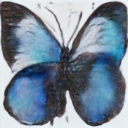

In [15]:
from diffusers import DiffusionPipeline
import torch

pipeline = DiffusionPipeline.from_pretrained("anton-l/ddpm-butterflies-128").to(t_device)
image = pipeline().images[0]
image

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

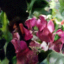

In [ ]:
pipeline = DiffusionPipeline.from_pretrained(OUTPUT_DIR).to(t_device)
image = pipeline().images[0]
image